# Springboard - Data Science Career Track

## Capstone Project II: Book Recommendations - Goodreads.com

Data: https://github.com/zygmuntz/goodbooks-10k

This dataset contains six million ratings for the ten thousand most popular (with most ratings) books. There are also:

- books marked to read by the users
- book metadata (author, year, etc.)
- tags/shelves/genres

**Goal of the project: Recommend books to Goodreads.com users**

**Table of contents:**

[1) Data Inspection and Cleaning](#data_cleaning)

[2) Exploratory Data Analysis](#eda)

[3) Building the Recommendation System](#recommender)


**API Key**

In [1]:
KEY = '0X3crFDSjHUTEHDPOlaFCg'
SECRET = 'ZAxgfS7OnTBnMCzRpwKEwao2TzjZEzO3cVVTWL9W8'

#### Libraries

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set()

from collections import Counter
from itertools import compress
from goodreads import client
from scipy.stats import normaltest, shapiro

from bokeh.io import output_notebook
output_notebook()
from bokeh.io import output_file, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import CategoricalColorMapper, Slider, HoverTool, Select
from bokeh.layouts import column, widgetbox

from tqdm import tqdm

import scipy.sparse as sparse
import random
from scipy.sparse.linalg import spsolve
import implicit

import xgboost as xgb

from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from PIL import Image
import requests
from io import BytesIO


Loading BokehJS ...

## 1) Data inspection and Cleaning
<a id="data_cleaning"></a>

### 1.1) Tags

***book_tags.csv*** contains tags/shelves/genres assigned by users to books. Tags in this file are represented by their IDs. They are sorted by goodreads_book_id ascending and count descending.

In [3]:
# book_tags
book_tags = pd.read_csv('book_tags.csv')
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


***tags.csv*** translates tag IDs to names.

In [4]:
# tags
tags = pd.read_csv('tags.csv')
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


Let's join these two tables: **tags_df**

In [5]:
# tags_df
tags_df = pd.merge(book_tags, tags, on='tag_id').sort_values('count', ascending=False).reset_index(drop=True)
tags_df

,goodreads_book_id,tag_id,count,tag_name
0,865,30574,596234,to-read
1,2429135,30574,586235,to-read
2,18143977,30574,505884,to-read
3,3,30574,496107,to-read
4,24280,30574,488469,to-read
5,11235712,30574,474954,to-read
6,168668,30574,465640,to-read
7,18405,30574,454565,to-read
8,4981,30574,443942,to-read
9,930,30574,436097,to-read


I don't understand what the last 6 negative values represent in the 'count' column, so I'm going to disconsider them

In [6]:
# disconsider count negative rows
tags_df = tags_df[:-6]
tags_df.tail()

,goodreads_book_id,tag_id,count,tag_name
999901,327246,5141,1,books-for-creators-and-artists
999902,327242,5141,1,books-for-creators-and-artists
999903,327242,22343,1,on-my-bookself-irl
999904,320700,28881,1,sub
999905,327242,32111,1,want-to-read-i-have


In [7]:
# info
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999906 entries, 0 to 999905
Data columns (total 4 columns):
goodreads_book_id    999906 non-null int64
tag_id               999906 non-null int64
count                999906 non-null int64
tag_name             999906 non-null object
dtypes: int64(3), object(1)
memory usage: 30.5+ MB


In [8]:
# number of unique tags
assert len(tags_df.tag_id.unique()) == len(tags_df.tag_name.unique())

len(tags_df.tag_name.unique())

34250

In [9]:
# most common tags
tags_df.tag_name.value_counts().head(10)

to-read              9983
favorites            9881
owned                9858
books-i-own          9799
currently-reading    9776
library              9415
owned-books          9221
fiction              9097
to-buy               8692
kindle               8316
Name: tag_name, dtype: int64

### 1.2) Ratings

***ratings.csv*** contains almost 6 million book ratings by users. Ratings can go from one to five stars, where:

 - **5 stars**: "it was amazing"
 - **4 stars**: "really liked it"
 - **3 stars**: "liked it"
 - **2 stars**: "it was ok"
 - **1 star**: "did not like it"
 


In [10]:
# ratings
ratings = pd.read_csv('ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [11]:
# info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
user_id    int64
book_id    int64
rating     int64
dtypes: int64(3)
memory usage: 136.8 MB


In [12]:
# check for missing values
ratings.isnull().values.any()

False

In [13]:
# number of books
len(ratings.book_id.unique())

10000

In [14]:
# number of unique users
len(ratings.user_id.unique())

53424

In [15]:
# check if there are book ratings duplications by users
ratings[ratings[['user_id', 'book_id']].duplicated()]

,user_id,book_id,rating


### 1.3) to read

***to_read.csv*** provides IDs of the books marked "to read" by each user.

In [16]:
# to_read
to_read = pd.read_csv('to_read.csv')
to_read.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [17]:
# to_read info
to_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912705 entries, 0 to 912704
Data columns (total 2 columns):
user_id    912705 non-null int64
book_id    912705 non-null int64
dtypes: int64(2)
memory usage: 13.9 MB


### 1.4) books

***books.csv*** has metadata for each book (goodreads IDs, authors, title, average rating, etc.). 

**goodreads IDs**:
    
Each book may have many editions. **goodreads_book_id** and **best_book_id** generally point to the most popular edition of a given book, while goodreads **work_id** refers to the book in the abstract sense.

It's possible to use the goodreads book and work IDs to create URLs as follows:

- https://www.goodreads.com/book/show/3
- https://www.goodreads.com/work/editions/4640799

Note that **book_id** in *ratings.csv* and *to_read.csv* maps to **work_id**, not to goodreads_book_id, **meaning that ratings for different editions are aggregated**.

In [18]:
# books
books = pd.read_csv('books.csv')
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


'books_count' is the number of editions for a given work. I'll change this name, for clarity, to **book_editions**:

In [19]:
# renaming the number of editions column
books = books.rename({'books_count': 'book_editions'}, axis=1)

In [20]:
# books info
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
book_id                      10000 non-null int64
goodreads_book_id            10000 non-null int64
best_book_id                 10000 non-null int64
work_id                      10000 non-null int64
book_editions                10000 non-null int64
isbn                         9300 non-null object
isbn13                       9415 non-null float64
authors                      10000 non-null object
original_publication_year    9979 non-null float64
original_title               9415 non-null object
title                        10000 non-null object
language_code                8916 non-null object
average_rating               10000 non-null float64
ratings_count                10000 non-null int64
work_ratings_count           10000 non-null int64
work_text_reviews_count      10000 non-null int64
ratings_1                    10000 non-null int64
ratings_2                    10000 n

 - **book_id, goodreads_book_id, best_book_id, and work_id** seem ok.

In [21]:
len(books.work_id.unique())

10000

In [22]:
# number of unique work_id's
len(books.work_id.unique()) == len(books.goodreads_book_id.unique())

True

 - There are some rows where the **isbn** and **isbn13** number are missing, but for now we will leave it like that and return later if necessary.

In [23]:
# where isbn miss
books[books['isbn'].isna()].head()

,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
105,106,9418327,9418327,14302659,48,NaN,NaN,Tina Fey,2011.0,Bossypants,...,506250,609260,35142,14842,31761,129390,230080,203187,https://images.gr-assets.com/books/1481509554m...,https://images.gr-assets.com/books/1481509554s...
120,121,7604,7604,1268631,370,NaN,NaN,"Vladimir Nabokov, Craig Raine",1955.0,Lolita,...,469836,517990,18107,21091,37205,108664,165477,185553,https://images.gr-assets.com/books/1377756377m...,https://images.gr-assets.com/books/1377756377s...
161,162,49552,49552,3324344,675,NaN,NaN,"Albert Camus, Matthew Ward",1942.0,L’Étranger,...,420600,483623,14836,10563,28920,100140,174957,169043,https://images.gr-assets.com/books/1349927872m...,https://images.gr-assets.com/books/1349927872s...
187,188,10664113,10664113,2936175,115,NaN,NaN,George R.R. Martin,2011.0,A Dance with Dragons,...,365954,424618,20072,2399,10150,53744,147136,211189,https://images.gr-assets.com/books/1327885335m...,https://images.gr-assets.com/books/1327885335s...
202,203,11505797,11505797,16441531,85,NaN,NaN,Jamie McGuire,2011.0,Beautiful Disaster,...,418309,442696,25298,17185,23298,61993,115123,225097,https://images.gr-assets.com/books/1358259032m...,https://images.gr-assets.com/books/1358259032s...


- **Authors**

In [24]:
# number of unique authors
len(books.authors.unique())

4664

- **Original publication year** - there are 21 missing values, but for now I will leave it like that.

In [25]:
# original_publication_year missing values
books['original_publication_year'].isna().sum()

21

- The same with **original_title**

In [26]:
# - The same with **original_title** missing values
books['original_title'].isna().sum()

585

- **Title**

In [27]:
# number of unique titles
len(books.title.unique())

9964

In [28]:
# titles that are not unique
print(books.title.value_counts()[:len([i for i in books.title.value_counts() if i > 1])])

print("\nNumber of not unique titles: {}".format(len([i for i in books.title.value_counts() if i > 1])))

Selected Poems                               4
Stone Soup                                   3
The Girls                                    2
The Gift                                     2
'Salem's Lot                                 2
Between the Lines (Between the Lines, #1)    2
Selected Stories                             2
The Collector                                2
The List                                     2
Leviathan                                    2
Monster                                      2
The Stranger                                 2
The Pact                                     2
Invisible                                    2
Bambi                                        2
The Complete Poems                           2
The Little Mermaid                           2
The Beach House                              2
Perfect                                      2
The Witness                                  2
The Collected Poems                          2
The Son      

In [29]:
# not unique titles
titles_not_uniq = books.title.value_counts()[:len([i for i in books.title.value_counts() if i > 1])].index

# check lines
check_titles = books[books.title.isin(titles_not_uniq)]

# number of them
print("Number of rows with non-unique titles: {}".format(check_titles.shape[0]))

# number of different authors
print("Number of different authors: {}".format(len(check_titles.authors.unique())))


Number of rows with non-unique titles: 69
Number of different authors: 66


In [30]:
# which 3 authors repeat?
repeat_auth = check_titles.authors.value_counts()[:3].index

# check again
books[(books.title.isin(titles_not_uniq)) & (books.authors.isin(repeat_auth))].iloc[:, :15]


,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count
2371,2372,12716613,12716613,17851429,75,399159371,9.780399e+12,Nora Roberts,2012.0,The Witness,The Witness,NaN,4.19,40943,49415
5173,5174,18668066,18668066,26493730,52,399171088,9.780399e+12,Nora Roberts,2014.0,The Collector,The Collector,eng,3.92,15888,22703
7024,7025,26506,26506,1008958,52,385340222,9.780385e+12,Danielle Steel,2007.0,Sisters,Sisters,eng,3.81,13621,14641
7448,7449,6345193,6345193,6448995,44,805090800,9.780805e+12,Paul Auster,2009.0,Invisible,Invisible,eng,3.71,11706,13897
7461,7462,456,456,1128381,50,140178139,9.780140e+12,Paul Auster,1992.0,Leviathan,Leviathan,eng,3.95,10002,11794
7683,7684,59836,59836,1912773,55,440221315,9.780440e+12,Danielle Steel,1986.0,The Gift,The Gift,en-US,3.91,12382,13114


When comparing the title and author columns on these cases we see there is nothing wrong with the data. They just wrote a book with the same title than other author did, and not twice as we can see.

- **language_code** - everything seems to be ok. Regarding the missing values, I will leave it like that for now.

In [31]:
# different languages
books.language_code.value_counts()

eng      6341
en-US    2070
en-GB     257
ara        64
en-CA      58
fre        25
ind        21
spa        20
ger        13
jpn         7
per         7
por         6
pol         6
en          4
dan         3
nor         3
ita         2
fil         2
rus         1
rum         1
vie         1
swe         1
mul         1
nl          1
tur         1
Name: language_code, dtype: int64

In [32]:
# missing values
books[books.language_code.isna()].head()

,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
44,45,4214,4214,1392700,264,770430074,9.780770e+12,Yann Martel,2001.0,Life of Pi,...,1003228,1077431,42962,39768,74331,218702,384164,360466,https://images.gr-assets.com/books/1320562005m...,https://images.gr-assets.com/books/1320562005s...
131,132,3431,3431,2561472,123,1401308589,9.781401e+12,Mitch Albom,2003.0,The Five People You Meet in Heaven,...,449501,474699,16682,12360,33669,107800,155830,165040,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
203,204,5326,5326,3097440,2380,1561797464,9.781562e+12,Charles Dickens,1843.0,A Christmas Carol,...,394540,441396,11568,6737,21415,93906,153823,165515,https://images.gr-assets.com/books/1406512317m...,https://images.gr-assets.com/books/1406512317s...
236,237,10592,10592,1552134,249,1416524304,9.781417e+12,Stephen King,1974.0,Carrie,...,356814,377650,8264,4564,19479,96352,136054,121201,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
287,288,19691,19691,1112006,117,425172902,9.780425e+12,Tom Clancy,1984.0,The Hunt for Red October,...,270318,278255,2117,9470,13707,49906,95296,109876,https://images.gr-assets.com/books/1281995542m...,https://images.gr-assets.com/books/1281995542s...


- **average_rating** seems ok.

In [33]:
# average rating of all books
books['average_rating'].mean()

4.002191000000001

In [34]:
# number of ratings in all books
books.work_ratings_count.sum()

596873216

- **ratings_count** or **work_ratings_count**

In [35]:
# question
books[['ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1' ,'ratings_2' ,'ratings_3',
       'ratings_4' ,'ratings_5']].head()

,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,4780653,4942365,155254,66715,127936,560092,1481305,2706317
1,4602479,4800065,75867,75504,101676,455024,1156318,3011543
2,3866839,3916824,95009,456191,436802,793319,875073,1355439
3,3198671,3340896,72586,60427,117415,446835,1001952,1714267
4,2683664,2773745,51992,86236,197621,606158,936012,947718


In [36]:
# check work_ratings_count
(np.sum(books[['ratings_1' ,'ratings_2' ,'ratings_3', 'ratings_4' ,'ratings_5']], axis=1) == 
 books['work_ratings_count']).sum()

10000

In [37]:
# check ratings_count
(np.sum(books[['ratings_1' ,'ratings_2' ,'ratings_3', 'ratings_4' ,'ratings_5']], axis=1) == 
 books['ratings_count']).sum()

14

It is the column **work_ratings_count** that corresponds to the total number of ratings per row/book.

- The columns representing the **ratings** from 1 to 5 seem ok, as **work_text_reviews_count** do.

- Finally, the last two columns - **image_url** and **small_image_url** - represent the image of the cover of the book. 

#### Access GoodReads API using the Goodreads package

In [38]:
from goodreads import client
gc = client.GoodreadsClient(KEY, SECRET)

**+ Book description**

- I will add a column in the books data frame regarding the **description** of each book, using the API: 

*Note: I did this separately in another notebook, and I will from now on use the file 'books_new.csv' instead of 'books.csv'*

In [39]:
%%script false 

# create empty series
books['description'] = np.empty

# adding the book description - text column
for i in range(len(books)):
    try:
        books['description'][i] = gc.book(books['goodreads_book_id'][i]).description
    except:
        None

# save to a new file, named books_new
books.to_csv('books_new.csv')

Couldn't find program: 'false'


In [40]:
# new dataframe, with the column 'description' added
books_new = pd.read_csv('books_new.csv').drop('Unnamed: 0', axis=1)
books_new.head(3)

,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,popular_shelves
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"Could you survive on your own, in the wild, wi...","[to-read, favorites, currently-reading, young-..."
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter's life is miserable. His parents ...,"[to-read, currently-reading, fantasy, favorite..."
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,<b>About three things I was absolutely positiv...,"[to-read, currently-reading, young-adult, fant..."


In [41]:
# see column 'description'
books_new['description'].describe()

count                          9986
unique                         2375
top       <built-in function empty>
freq                           7612
Name: description, dtype: object

There are 14 missing book descriptions.

In [42]:
# example of book description
books_new['description'][0]

"Could you survive on your own, in the wild, with everyone out to make sure you don't live to see the morning?<br /><br />In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and one girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV. Sixteen-year-old Katniss Everdeen, who lives alone with her mother and younger sister, regards it as a death sentence when she is forced to represent her district in the Games. But Katniss has been close to dead before - and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weigh survival against humanity and life against love.<br /><br />New York Times bestselling author Suzanne Collins delivers equal par

**+ Popular shelves**

- I will also add the **most popular shelves** the book is in, also using the Goodreads API

In [43]:
%%script false 

# create empty series
books['popular_shelves'] = np.empty

# adding the most popular shelves - text column
for i in range(len(books)):
    try:
        books['popular_shelves'][i] = gc.book(books['goodreads_book_id'][i]).popular_shelves
    except:
        None

# save to the new file, named books_new - we can overwrite
books.to_csv('books_new.csv')

Couldn't find program: 'false'


In [44]:
# new dataframe, with the column 'popular_shelves' added
books_new = pd.read_csv('books_new.csv').drop('Unnamed: 0', axis=1)
books_new.head(3)

,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,popular_shelves
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"Could you survive on your own, in the wild, wi...","[to-read, favorites, currently-reading, young-..."
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter's life is miserable. His parents ...,"[to-read, currently-reading, fantasy, favorite..."
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,<b>About three things I was absolutely positiv...,"[to-read, currently-reading, young-adult, fant..."


In [45]:
# see column 'popular_shelves'
books_new['popular_shelves'].describe()

count                         10000
unique                         8969
top       <built-in function empty>
freq                           1030
Name: popular_shelves, dtype: object

In [46]:
# example of popular shelves of a book
books_new['popular_shelves'][0]

'[to-read, favorites, currently-reading, young-adult, fiction, dystopian, ya, fantasy, dystopia, science-fiction, books-i-own, sci-fi, owned, series, favourites, romance, adventure, hunger-games, owned-books, book-club, kindle, teen, my-books, post-apocalyptic, the-hunger-games, favorite-books, read-in-2012, re-read, action, all-time-favorites, suzanne-collins, ya-fiction, 5-stars, books, sci-fi-fantasy, favorite, scifi, survival, audiobook, novels, ebook, i-own, audiobooks, young-adult-fiction, read-in-2011, thriller, my-favorites, default, library, ebooks, fantasy-sci-fi, reread, read-2012, faves, futuristic, my-library, suspense, audio, read-in-2010, shelfari-favorites, ya-books, ya-lit, favs, finished, teen-fiction, favorite-series, own-it, distopia, action-adventure, love-triangle, love, english, dystopian-fiction, coming-of-age, distopian, ya-fantasy, loved, novel, read-more-than-once, read-in-2013, borrowed, on-my-shelf, ya-dystopian, scifi-fantasy, favourite, bookshelf, to-buy,

## 2) Exploratory Data Analysis
<a id="eda"></a>

### **Tags**

In [47]:
# Exploring tags
tags_df.head()

,goodreads_book_id,tag_id,count,tag_name
0,865,30574,596234,to-read
1,2429135,30574,586235,to-read
2,18143977,30574,505884,to-read
3,3,30574,496107,to-read
4,24280,30574,488469,to-read


### - **What are the most common tags?**

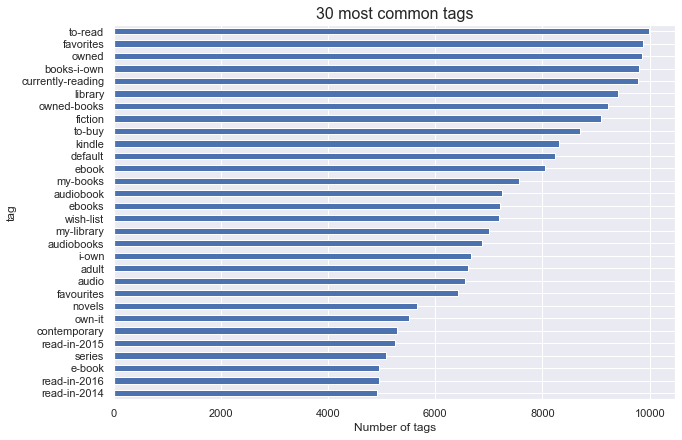

In [48]:
n = 30

# most tagged names
tags_df['tag_name'].value_counts(ascending=True)[-n:].plot(kind='barh')

plt.title("{} most common tags".format(n), fontsize=16)
plt.xlabel("Number of tags")
plt.ylabel("tag")

plt.subplots_adjust(left=0, bottom=-0.3, right=1.3, top=1, wspace=0, hspace=0)
plt.show()

Although "to-read" appears at the top of the list, some tags that have the same meaning easily surpass it when aggregated. For example, "owned", "books-i-own", owned-books" and "my-books" means the same.

### - What are the most common genres? 

Let us take a look at the main genres. To do that I picked a list with genres from the web and added some relevant names. I will base the analysis on tag names.

In [49]:
# list of genres taken from the web, plus others added manually. Added the '-'
genres = ["Art", "Adventure", "Biography", "Business", "Chick-Lit", "Children", "Christian", "Classics", "Comics", 
          "Contemporary", "Cookbook", "Crime", "Fantasy", "Fiction", "Gay-and-Lesbian", "Graphic-Novels",
          "Historical-Fiction", "Health", "History", "Horror", "Humor", "Comedy", "Manga", "Math", "Memoir", "Music", 
          "Mystery", "New-Age", "Nonfiction", "Paranormal", "Philosophy", "Poetry", "Psychology", "Religion", "Romance",
          "Science", "Science-Fiction", "sci-fi-fantasy", "Self-Help", "Suspense", "Spirituality", "Sports", "Thriller", 
          "Travel", "Young-Adult", 
          
          # add
          "adult", "novels", "action", "supernatural", "funny", "mystery-suspense", 
         "autobiography", "murder", "murder-mystery", "paranormal-fantasy", "spiritual", "satire", "short-story",
         "picture", "political-thriller", "fairytale", "drama", "alternate-history", "graphic-novel",
         "encyclopedia", "guide", 
          
          # add plural/singular
          "arts", "adventures", "biographies", "classic", "crimes", "maths", "memoirs", "religions", "romances", 
          "sciences", "sport", "thrillers", "travels",
         "adults", "novel", "murders", "guides"]    

# take lowercase
genres = [i.lower() for i in genres]

# build dataframe
genres_df = pd.DataFrame({
                'genre': genres,
                'nr': [tags_df['tag_name'].value_counts().loc[genres[i]] for i in range(len(genres))]}).sort_values(
    'nr', ascending=True).reset_index(drop=True)

In [50]:
# join genres with the same meaning
genre_singular = ["art", "adventure", "biography", "classic", "crime", "math", "memoir", "religion",  
                 "romance", "science", "sport", "thriller", "travel", "adult", "novel", "murder", "guide"]

genre_plural = ["arts", "adventures", "biographies", "classics", "crimes", "maths", "memoirs", "religions",  
                "romances", "sciences", "sports", "thrillers", "travels", "adults", "novels", "murders", "guides"]

# sum and drop the unnecessary rows
for i, j in zip(genre_singular, genre_plural):
    # sum
    genres_df.loc[genres_df['genre'] == i, 'nr'] = genres_df[genres_df['genre'] == i]['nr'].iloc[0] + \
                                                   genres_df[genres_df['genre'] == j]['nr'].iloc[0]
    # drop the plural
    genres_df.drop(genres_df.index[genres_df[genres_df['genre'] == j].index], inplace=True)
    genres_df.reset_index(inplace=True, drop=True)    

In [51]:
# reorder
genres_df = genres_df.sort_values('nr', ascending=True)

# genres df
genres_df.head()

,genre,nr
0,encyclopedia,3
1,gay-and-lesbian,7
2,guide,35
4,new-age,63
3,math,67


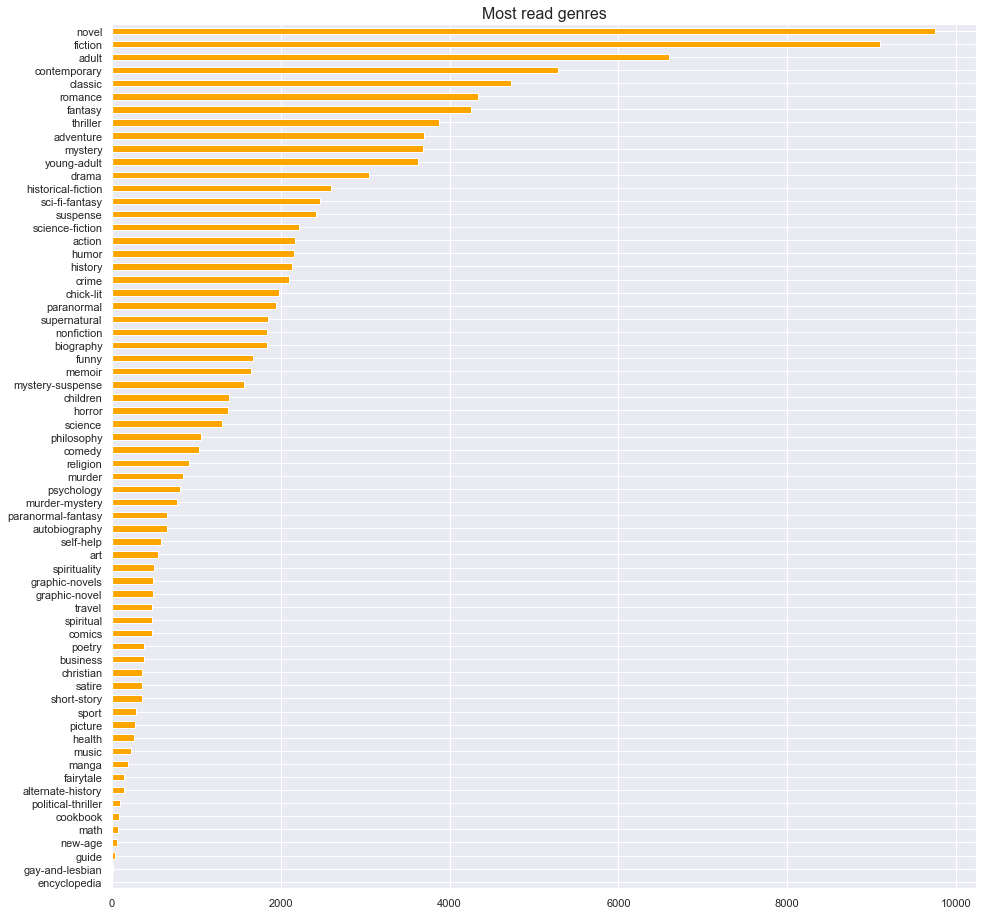

In [52]:
# barplot
genres_df['nr'].plot(kind='barh', color='orange')

plt.title("Most read genres", fontsize=16)
plt.yticks(np.arange(0, len(genres_df)), genres_df['genre'])

plt.subplots_adjust(left=0, bottom=-2, right=2, top=1, wspace=0, hspace=0)
plt.show()

It seems that fiction books, mainly of the genre "adult", "novel"/"romance", "contemporary" and "fantasy" are amongst the most read genres by users.

### **Ratings**

In [53]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


### - **How are ratings distributed? Do people tend to give higher or lower ratings?**

In [54]:
# count ratings
ratings['rating'].value_counts().sort_index(ascending=False)

5    1983093
4    2139018
3    1370916
2     359257
1     124195
Name: rating, dtype: int64

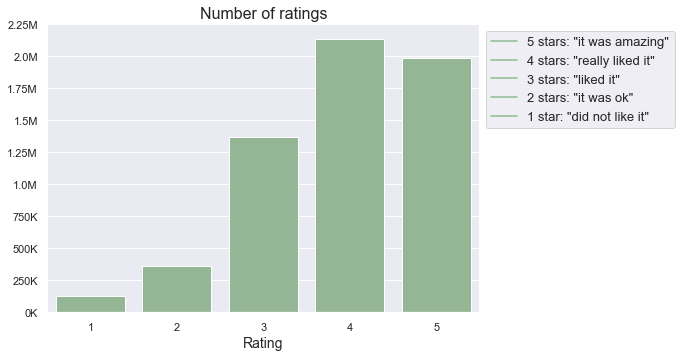

In [55]:
# count ratings
sns.countplot(x='rating', data=ratings, color='darkseagreen')

plt.title("Number of ratings", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("", fontsize=14)

# defining legend 
one = mlines.Line2D([], [], color='darkseagreen', label='1 star: "did not like it"')
two = mlines.Line2D([], [], color='darkseagreen', label='2 stars: "it was ok"')
three = mlines.Line2D([], [], color='darkseagreen', label='3 stars: "liked it"')
four = mlines.Line2D([], [], color='darkseagreen', label='4 stars: "really liked it"')
five = mlines.Line2D([], [], color='darkseagreen', label='5 stars: "it was amazing"')
plt.legend(handles=[five, four, three, two, one], bbox_to_anchor=(1, 1), fontsize=13)

plt.yticks(np.arange(0, 2500000, 250000), 
           ["{}K".format(250*i) for i in range(4)] + ["{}M".format(1+i*0.25) for i in range(0, 6)])

plt.subplots_adjust(left=0, bottom=-0, right=1, top=1, wspace=0, hspace=0)
plt.show()

In [56]:
# percentage of 4 and 5 stars
print("4 and 5 stars percentage: {}".format(ratings['rating'].isin([4, 5]).sum() / len(ratings)))
print("3, 4 and 5 stars percentage: {}".format(ratings['rating'].isin([3, 4, 5]).sum() / len(ratings)))

4 and 5 stars percentage: 0.6897223264734972
3, 4 and 5 stars percentage: 0.9191075547994061


In [57]:
# average rating
print("Ratings mean: {}".format(round(ratings['rating'].mean(), 1)))
print("Ratings median: {}".format(round(ratings['rating'].median(), 1)))

Ratings mean: 3.9
Ratings median: 4.0


Regarding our users data set, we see that **almost 70%** of the ratings are classified as either **"it was amazing"** (5 stars) or **"really liked it"** (4 stars). We can say that in general users give good ratings. This is not surprising since this is a data set for only popular books and, among other reasons, the users are the ones who choose the books they are going to read and the topics they are going to pursue, according to their interests. If you add a **"liked it"** rating (3 stars), the percentage goes up to **91%**.

The average rating is in fact 3.9, nearly close to a "really liked it" evaluation, which is very close to the mean of all books (596873216) data frame as we've seen above (4.002191000000001). The median is 4.

### - **Does the distribution of the number of ratings given follow a normal distribution?**

In [58]:
# number of users
print("Number of users: {}".format(len(ratings['user_id'].unique())))

Number of users: 53424


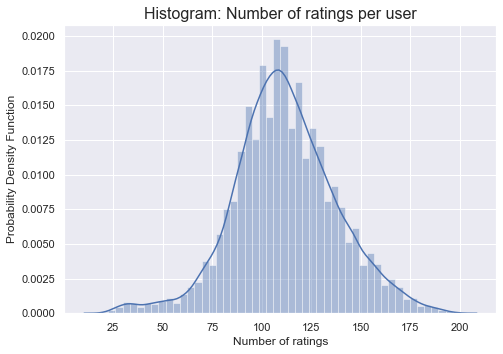

In [59]:
# user's number of ratings given distribution

list_ratings = list(ratings['user_id'].value_counts())

# histogram
sns.distplot(list_ratings)

plt.title("Histogram: Number of ratings per user", fontsize=16)
plt.xlabel("Number of ratings")
plt.ylabel("Probability Density Function")

plt.subplots_adjust(left=0, bottom=-0, right=1, top=1, wspace=0, hspace=0)
plt.show()

The Kernel Density Estimate which can be seen in the plot above does not suggest that, but we will check with a normality test: D'Agostino's K-squared test. The null hypothesis assumes normality of the distribution.

In [60]:
# D'Agostino's K-squared test
stat, p_value = normaltest(list_ratings)

print("D'Agostino's K-squared test: statistic=%.3f; p-value=%.3f" % (stat, p_value))

D'Agostino's K-squared test: statistic=460.696; p-value=0.000


Since the p-value is practically zero, we have the statistical evidence to **reject** the hypothesis that the number of ratings given follows a normal distribution. Looking at the distribution, we see that it is somewhat **left-skewed**.

### - **Can we have a 95% confidence interval for the mean of the ratings an user gives?**

I'll assume that the data is representative of the population. The diversity in book genre is pretty widespread and users that rate the most popular books and have this many ratings given on average is good enough.

We can make for now some inferences about the population of Goodreads users using the data in 'ratings.csv' (6 million ratings) - it may be useful when making recommendations later.

The conditions for assuming the Central Limit Theorem implications are met here, since:

 - the sample is more or less symmetric and bigger than 30, the value normally assumed for the validity of the Central Limit Theorem.
 - there was no replacement when retrieving the sample, but the observations are considered to be independent, since they constitute less than 10% of the population size (the 10% rule).
 - the sample was taken randomly (I assumed that it was).

In [61]:
# create a bootstrap confidence interval for the mean

# bootstrap replica function
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# Generate *size* bootstrap replicates function
def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for i in range(size)])


# 10000 bootstrap replicas of the mean
bs_replicates = draw_bs_reps(list_ratings, np.mean, 10000)

# (Bootstrap) 95% Confidence interval - we apply the Central Limit Theorem
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
conf_int

array([111.6504834 , 112.09271863])

In [62]:
# observed mean
np.mean(list_ratings)

111.86880428271938

This is a pretty close range. **If we repeated measurements over and over again, 95% of the observed values for the mean of the number of ratings given by users would be very close to 112**.

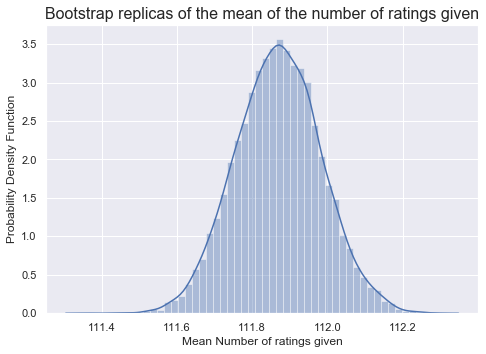

In [63]:
# histogram
sns.distplot(bs_replicates)

plt.title("Bootstrap replicas of the mean of the number of ratings given", fontsize=16)
plt.xlabel("Mean Number of ratings given")
plt.ylabel("Probability Density Function")

plt.subplots_adjust(left=0, bottom=-0, right=1, top=1, wspace=0, hspace=0)
plt.show()

In [64]:
# Standard error of the mean (SEM) - from the bootstrap replicates
np.std(bs_replicates)

0.11282104232173285

In [65]:
# Standard error of the mean (SEM) - known expression
np.std(list_ratings) / np.sqrt(len(list_ratings))

0.11279482071209866

### - **Do DISTRIBUTIONS of ratings among users vary significantly?**

For a sample of 30 users:


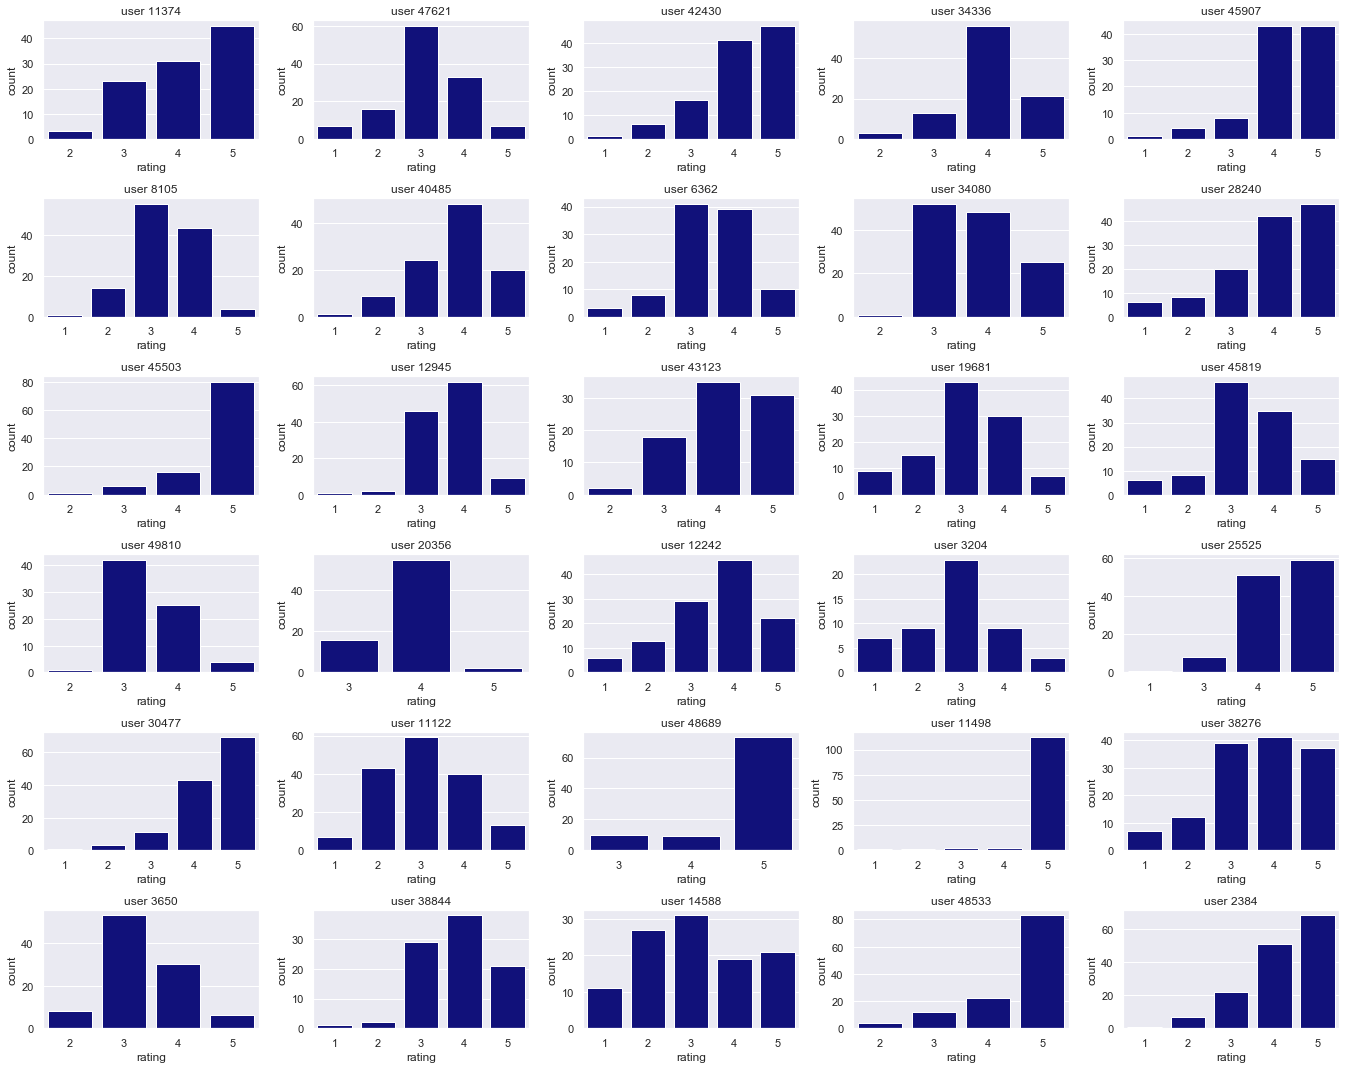

In [66]:
# Here is a sample of distributions among some random users

n = 30
sample_users = np.random.choice(ratings['user_id'].unique(), size=n, replace=False)

print("For a sample of {} users:".format(n))

for i, j in enumerate(sample_users):
    row = n / 5 # want 5 plots per row
    plt.subplot(row, 5, i+1)
    sns.countplot(ratings[ratings['user_id'] == j].rating, color='darkblue')
    plt.title("user {}".format(sample_users[i]))
    
plt.subplots_adjust(left=0, bottom=-2.5, right=3, top=1, wspace=0.25, hspace=0.5)
plt.show()


It is straightforward to see that the distributions of ratings vary significantly among users. We can see right away that the average rating by users are also different.

### - **How does the AVERAGE rating given by a user evolves as the number of his/her number of given ratings increases, on average? Do people tend to become more critic and give lower ratings?**

I will first create a new data frame with user_id, number of ratings given and average rating.

In [67]:
%%script false 

# create dataframe with user_id, number of ratings given and average rating
user_ratings = pd.DataFrame({'user_id': ratings['user_id'].value_counts().index, 
     'number_ratings': ratings['user_id'].value_counts(),
     'avg_rating': [ratings[ratings['user_id'] == i].rating.mean() for i in ratings['user_id'].value_counts().index]})

# save to disk
user_ratings.to_csv('user_ratings.csv')

Couldn't find program: 'false'


In [68]:
# load and check
user_ratings = pd.read_csv('user_ratings.csv').drop('Unnamed: 0', axis=1)
user_ratings.head()

,user_id,number_ratings,avg_rating
0,30944,200,4.210000
1,12874,200,3.450000
2,52036,199,3.442211
3,28158,199,3.939698
4,12381,199,3.427136


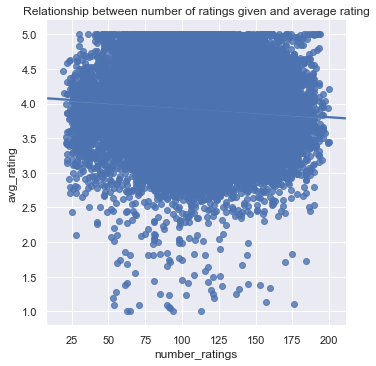

In [69]:
# relationship between number of ratings given and average rating
sns.lmplot('number_ratings', 'avg_rating', data=user_ratings)
plt.title("Relationship between number of ratings given and average rating")
plt.show()

In order to properly see the relationship I am going to agglomerate the users with the same number of given ratings and compute the average of their average rating given. Otherwise I would have almost 6 million points on the scatter plot as seen above. In any case, it's a negative relationship.

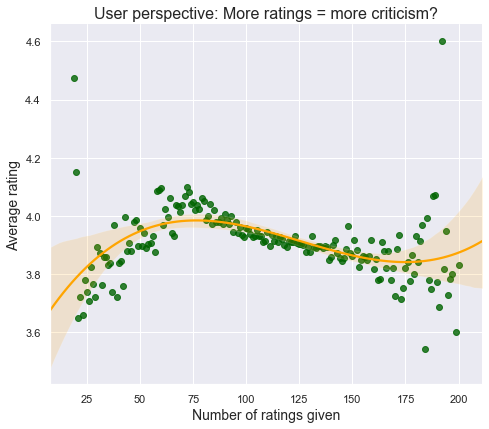

In [70]:
# unique given number of ratings
nr_ratings = user_ratings['number_ratings'].unique()

# average of the average rating given 
avg_avg_rating = [user_ratings[user_ratings['number_ratings'] == i].avg_rating.mean() for i in nr_ratings]

# new dataframe
evolv_rating = pd.DataFrame({'nr_ratings': nr_ratings, 'avg_avg_rating': avg_avg_rating})

# scatter plot
sns.lmplot('nr_ratings', 'avg_avg_rating', data=evolv_rating, order=3, line_kws={'color': 'orange'}, 
          scatter_kws={'color': 'darkgreen'})

plt.title("User perspective: More ratings = more criticism?", fontsize=16)
plt.xlabel("Number of ratings given", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=0, right=1.2, top=1, wspace=0, hspace=0)
plt.show()


Each point encompasses a different number of users. As we have seen in the previous histogram, most of the data resides between 75 and 150 ratings given. In fact, almost 90%, as computed below. Curiously, we see here that up until 75 ratings given by a "user" the average rating tends to increase and probably the enthusiasm for books and reading as well. After that, and until 150, which is exactly the range where most of the data is, the average rating linearly decreases as the number of ratings increase. It then spreads across the range between 3.5 and 4.6 without a clear tendency.

**This may suggest that, on average, the user tends to become more critic and give lower ratings as it reads more books.**

In [71]:
# percentile: 90% of the data regarding the number of ratings given is between
data_90 = np.percentile(list_ratings, [5, 95])
data_90

array([ 71., 157.])

Taking now a closer look at the relevant range, we see more clearly this negative relationship:

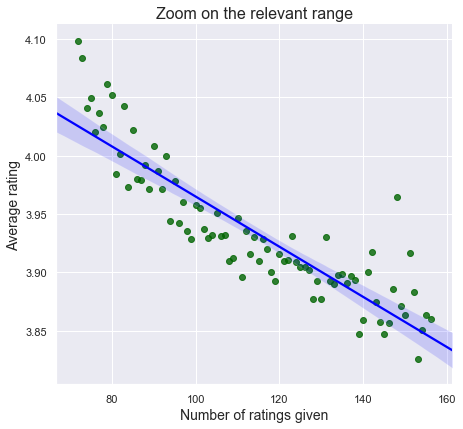

In [72]:
# see the relationship within the relevant range
new_nr_ratings = [i for i in nr_ratings if np.logical_and(i > data_90[0], i < data_90[1])]
new_avg_avg_rating = list(compress(avg_avg_rating, np.logical_and(nr_ratings > data_90[0], nr_ratings < data_90[1])))

# new dataframe
evolv_rating_2 = pd.DataFrame({'new_nr_ratings': new_nr_ratings, 'new_avg_avg_rating': new_avg_avg_rating})

# scatter plot
sns.lmplot('new_nr_ratings', 'new_avg_avg_rating', data=evolv_rating_2, order=1, line_kws={'color': 'blue'}, 
          scatter_kws={'color': 'darkgreen'})

plt.title("Zoom on the relevant range", fontsize=16)
plt.xlabel("Number of ratings given", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

In [73]:
# Correlation coefficient
np.corrcoef(new_nr_ratings, new_avg_avg_rating)[0, 1]

-0.8921774341616135

There is a **very strong negative correlation** between the number of ratings a user has given and the average rating, suggesting, again, that the user tends to become less enthusiastic, on average, as he/she reads more books.

###  - **How does the distribution of ratings given by a user evolve as the number of ratings increases, on average?**

In [74]:
# previously constructed data frame
user_ratings.head()

,user_id,number_ratings,avg_rating
0,30944,200,4.210000
1,12874,200,3.450000
2,52036,199,3.442211
3,28158,199,3.939698
4,12381,199,3.427136


In [75]:
# bokeh

# pick a spacely ordered group of different number of users (since they are ordered by ratings given in 'user_ratings')
n = 99
list_nr = user_ratings['user_id']  # they are by decreasing order of number of ratings given

# bokeh plot
def modify_doc(doc):
    n = len(list_nr)-1
    source = ColumnDataSource(
        data={'ratings': np.arange(1, 6),
            'counts': [ratings[ratings['user_id'] == list_nr[0]].rating.tolist().count(i) for i in np.arange(1, 6)]})
    
    # Create plots and widgets
    plot = figure(width=600, height=400)
    plot.vbar(x='ratings', top='counts', source=source, width=1)
    
    # Make a slider object: slider
    slider = Slider(start=0, end=n, step=1, value=0, title='Distribution of ratings')

    # Define the callback function: update_plot
    def update_plot(attr, old, new):
        
        # Set the nr name to slider.value and new_data to source.data
        nr = slider.value
        
        new_data = {'ratings': np.arange(1, 6),
            'counts': [ratings[ratings['user_id'] == list_nr[nr]].rating.tolist().count(i) for i in np.arange(1, 6)]}
        
        source.data = new_data
        
        # Add title to figure: plot.title.text
        plot.title.text = 'Ratings given by user {}: {}'.format(list_nr[nr], 
             np.sum([ratings[ratings['user_id'] == list_nr[nr]].rating.tolist().count(i) for i in np.arange(1, 6)]))


    # Attach the callback to the 'value' property of slider
    slider.on_change('value', update_plot)
    
    # Arrange plots and widgets in layouts
    layout = column(slider, plot)
    doc.add_root(layout)

show(modify_doc) 

As we can see, there is also a **tendency to make the distribution skewed to the right, as the number of given ratings increase**.

### - How does the average rating of a book relate to the number of ratings it has received?

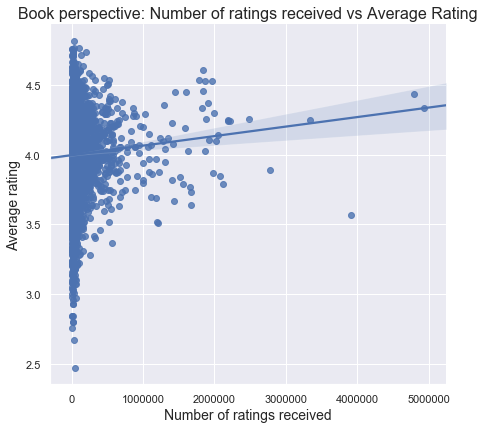

In [76]:
# lmplot
sns.lmplot('work_ratings_count', 'average_rating', data=books_new)

plt.title("Book perspective: Number of ratings received vs Average Rating", fontsize=16)
plt.xlabel("Number of ratings received", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

This shows us the **slight positive relationship between the number of ratings (or fame) a book has received and its average rating**.

In [77]:
# Correlation coefficient
corr_coeff_observed = np.corrcoef(books_new['work_ratings_count'], books_new['average_rating'])[0, 1]
corr_coeff_observed

0.045041585239400515

- Can we be sure this correlation is not by chance? To know that I will do a test of correlation.

**Hypothesis test:**
    
   - **Null hypothesis**: "the two variables are completely uncorrelated"
   - **Alternate hypothesis**: "the two variables are correlated"
   - **Test statistic**: "pearson correlation coefficient"    

In [78]:
# pearson correlation definition
def pearson_corr_coeff(data_1, data_2):
    return np.corrcoef(data_1, data_2)[0, 1]

# 1 permutation formula
def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

# permutations of size n
def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)

    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

######################################

# 10 000 permutations
permutations = draw_perm_reps(books_new['work_ratings_count'], books_new['average_rating'], pearson_corr_coeff, size=10000)

p_value = np.sum(permutations >= corr_coeff_observed) / len(permutations)

print("\np-value:", p_value)


p-value: 0.0053


We **reject the hypothesis that the two variables are not correlated**, considering a level of significance of 1%. As the number of ratings a book gets increases, the higher the chance that it will have a higher average rating. In any case, there is too much noise and the correlation is not clear.

### **Books**

In [79]:
# books_new
books_new.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'book_editions', 'isbn', 'isbn13', 'authors',
       'original_publication_year', 'original_title', 'title', 'language_code',
       'average_rating', 'ratings_count', 'work_ratings_count',
       'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3',
       'ratings_4', 'ratings_5', 'image_url', 'small_image_url', 'description',
       'popular_shelves'],
      dtype='object')

### - What are the most famous books?

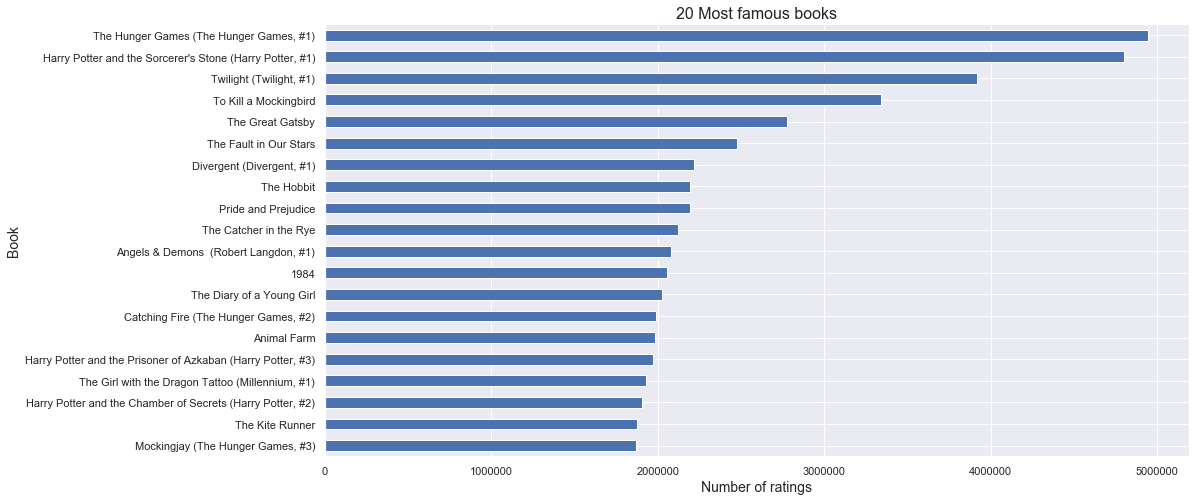

In [80]:
n = 20

# sorting by work_ratings_count
famous_books = books_new.sort_values('work_ratings_count', ascending=True).title[-n:]
famous_books_count_ratings = books_new.sort_values('work_ratings_count', ascending=True).work_ratings_count[-n:]

famous_books_count_ratings.plot(kind='barh')

plt.title("{} Most famous books".format(n), fontsize=16)
plt.xlabel("Number of ratings", fontsize=14)
plt.ylabel("Book", fontsize=14)
plt.yticks(np.arange(0, n), famous_books)

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

### - What are the most beloved books?

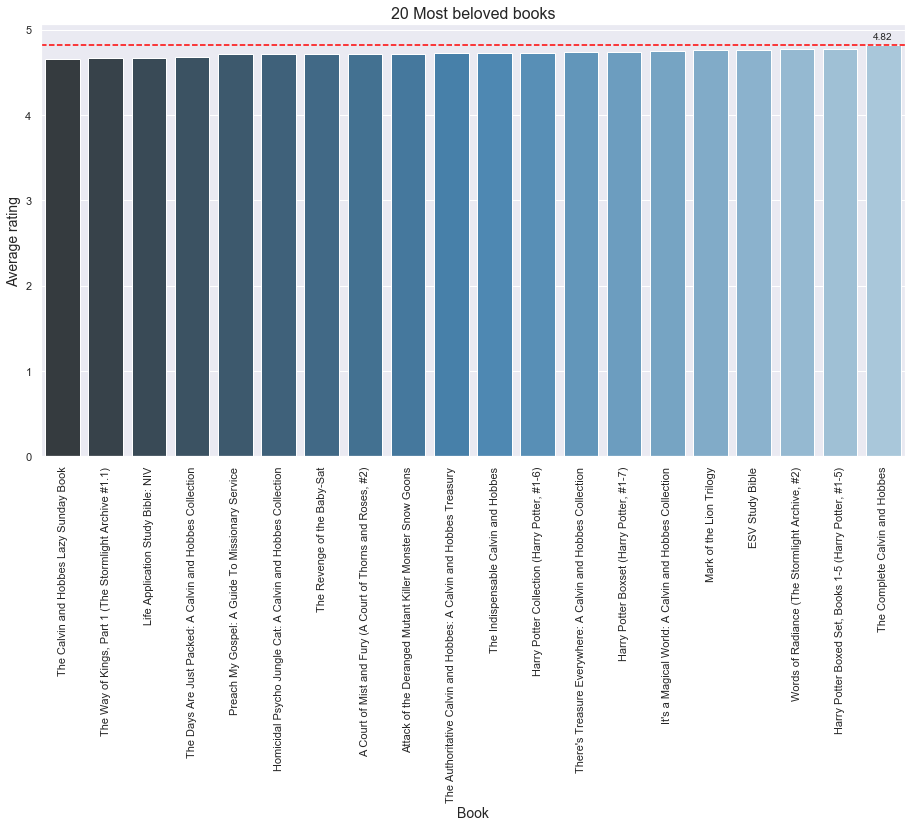

In [81]:
n = 20

# sorting by work_ratings_count
famous_books = books_new.sort_values('average_rating', ascending=True).title[-n:]
famous_books_avg_ratings = books_new.sort_values('average_rating', ascending=True).average_rating[-n:]

sns.barplot(famous_books, famous_books_avg_ratings, palette="Blues_d")

plt.title("{} Most beloved books".format(n), fontsize=16)
plt.xlabel("Book", fontsize=14)
plt.ylabel("Average rating", fontsize=14)
plt.xticks(rotation=90)
plt.axhline(y=famous_books_avg_ratings.max(), color='red', linestyle="--")
plt.annotate(famous_books_avg_ratings.iloc[-1], xy=(n-1.25, famous_books_avg_ratings.max()+0.1), va='center')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

### - What are the most read languages?

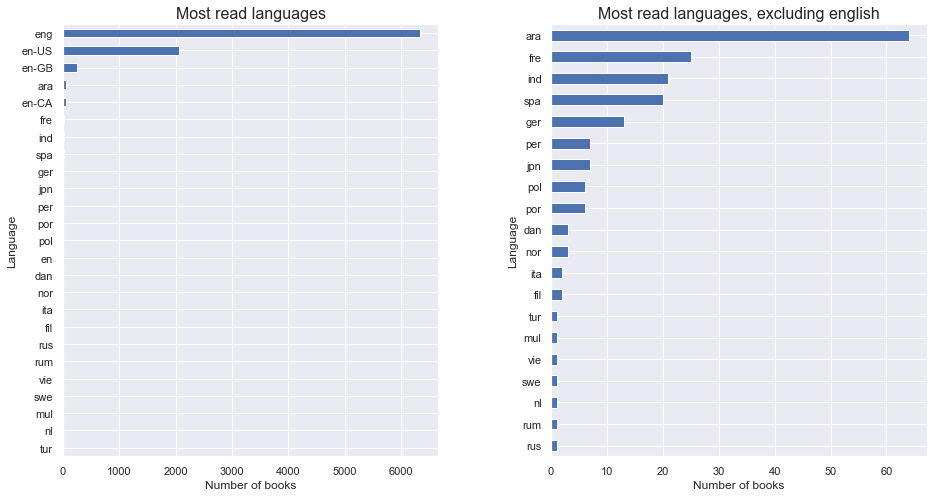

In [82]:
# Considering the english language
plt.subplot(1, 2, 1)
books_new['language_code'].value_counts(ascending=True).plot(kind='barh')
plt.title("Most read languages", fontsize=16)
plt.xlabel("Number of books")
plt.ylabel("Language")

# not considering the english language
english_lang = ['eng', 'en-US', 'en-CA', 'en-GB', 'en', np.nan]
not_english = [i for i in Counter(books_new['language_code']).keys() if i not in english_lang]
not_english_read = [Counter(books_new['language_code'])[j] for j in not_english]

not_english_df = pd.DataFrame({'language': not_english, 'number': not_english_read}).sort_values(
                                'number').reset_index(drop=True)

plt.subplot(1, 2, 2)
not_english_df['number'].plot(kind='barh')

plt.title("Most read languages, excluding english", fontsize=16)
plt.xlabel("Number of books")
plt.ylabel("Language")
plt.yticks(np.arange(0, len(not_english_df)), not_english_df['language'])

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.3, hspace=0)
plt.show()

English is by far the most read language, and almost the only one in this data set, in relative terms.

### - Is having more authors better?

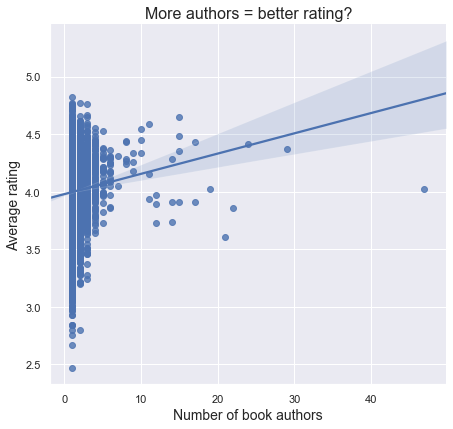

In [83]:
# create column with number of authors (separated by comma)
books_new['nr_authors'] = [len(books_new.authors[i].split(',')) for i in range(len(books_new))]

# plot
sns.lmplot('nr_authors', 'average_rating', data=books_new)

plt.title("More authors = better rating?", fontsize=16)
plt.xlabel("Number of book authors", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

In [84]:
# Correlation coefficient
corr_coeff_observed = np.corrcoef(books_new['nr_authors'], books_new['average_rating'])[0, 1]
corr_coeff_observed

0.07451450574104693

Here the correlation is slightly more positive: **as the number of authors increases, so does the average rating**.

### - Does the length of the title influence the average rating?

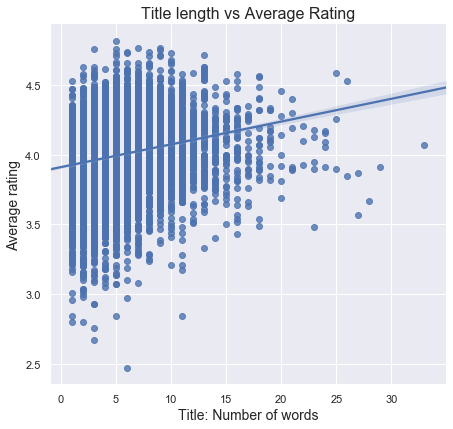

In [85]:
# new column with the length of the title
books_new['len_title'] = [len(books_new.title[i].split()) for i in range(len(books_new))]

# plot
sns.lmplot('len_title', 'average_rating', data=books_new)

plt.title("Title length vs Average Rating", fontsize=16)
plt.xlabel("Title: Number of words", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

In [86]:
# Correlation coefficient
corr_coeff_observed = np.corrcoef(books_new['len_title'], books_new['average_rating'])[0, 1]
corr_coeff_observed

0.21025544307974478

There is also a small positive correlation between the length of the title and the average rating.

## 3) Building the Recommendation System
<a id="recommender"></a>

Dataframes

In [87]:
# tags_df
tags_df.head(3)

,goodreads_book_id,tag_id,count,tag_name
0,865,30574,596234,to-read
1,2429135,30574,586235,to-read
2,18143977,30574,505884,to-read


In [88]:
# to_read
to_read.head(3)

,user_id,book_id
0,9,8
1,15,398
2,15,275


In [89]:
# ratings
ratings.head(3)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5


In [90]:
# user_ratings
user_ratings.head(3)

,user_id,number_ratings,avg_rating
0,30944,200,4.210000
1,12874,200,3.450000
2,52036,199,3.442211


In [91]:
# books_new
print(books_new.columns)
books_new.head(2)

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'book_editions', 'isbn', 'isbn13', 'authors',
       'original_publication_year', 'original_title', 'title', 'language_code',
       'average_rating', 'ratings_count', 'work_ratings_count',
       'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3',
       'ratings_4', 'ratings_5', 'image_url', 'small_image_url', 'description',
       'popular_shelves', 'nr_authors', 'len_title'],
      dtype='object')


,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,popular_shelves,nr_authors,len_title
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"Could you survive on your own, in the wild, wi...","[to-read, favorites, currently-reading, young-...",1,7
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter's life is miserable. His parents ...,"[to-read, currently-reading, fantasy, favorite...",2,9


In [92]:
# genres df
genres_df.tail(3)

,genre,nr
64,adult,6605
65,fiction,9097
60,novel,9749


In [93]:
###############################################

I will start by building an implicit matrix factorization algorithm using the Alternating Least Squares (ALS)
algorithm and then train an efficient Gradient Boosting Decision Tree ensemble using scikit-learn's Extreme Gradient Boosting Classifier (XGBClassifier).

### 3.1) Build a matrix factorization algorithm using ALS (Alternating Least Squares) for implicit feedback

In [94]:
# copy of the ratings dataframe
ratings_data = ratings.copy()
ratings_data.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [95]:
# list of unique users
users_unique = list(np.sort(ratings_data['user_id'].unique()))

# list of unique book id's
books_unique = list(ratings_data['book_id'].unique())

# All ratings
list_ratings = list(ratings_data['rating'])

print("There are {} unique users and {} unique books.".format(len(users_unique), len(books_unique)))

There are 53424 unique users and 10000 unique books.


In [96]:
# Create the sparse matrix

# associated row indices
rows = ratings_data['user_id'].astype(pd.api.types.CategoricalDtype(categories = users_unique)).cat.codes

# associated column indices
cols = ratings_data['book_id'].astype(pd.api.types.CategoricalDtype(categories = books_unique)).cat.codes

# sparse matrix
ratings_sparse = sparse.csr_matrix((list_ratings, (rows, cols)), shape=(len(users_unique), len(books_unique)))
ratings_sparse

<53424x10000 sparse matrix of type '<class 'numpy.int32'>'
	with 5976479 stored elements in Compressed Sparse Row format>

Here is the sparse matrix, where each row represents an user and each column a given book:

In [97]:
# sparse matrix: 53424 users x 10000 books
ratings_sparse.toarray()

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 4, 5, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [98]:
# Number of possible interactions in the matrix
matrix_size = ratings_sparse.shape[0] * ratings_sparse.shape[1] 
print("The number of possible interactions in the matrix is equal to {}.".format(matrix_size))

# Number of books interacted with
num_readings = len(ratings_sparse.nonzero()[0])  

# Calculate sparsity
sparsity = (1 - (num_readings / matrix_size))*100

print("\nSparsity: {}%".format(round(sparsity, 1)))

The number of possible interactions in the matrix is equal to 534240000.

Sparsity: 98.9%


As we can see, with this sparsity value, most of the matrix is filled with 0's. It makes sense since, although we are dealing with the most popular books, there are 10000 of them.

I will now define a function, **make_train**, which takes the original user-book matrix and "mask" a percentage of the original ratings where a user-book interaction has taken place. The test set will contain all of the original ratings (but with binary choice), while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 

In [99]:
def make_train(ratings_matrix, pct_test = 0.2):
    '''
    parameters: 
    
    ratings_matrix - The original ratings_matrix from which you want to generate a train/test set. 
    The test is just a complete copy of the original set.
    This is in the form of a sparse 'Compressed Sparse Row' format matrix. 
    
    pct_test - The percentage of user-book interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set (which contains all of the original ratings). 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-book pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-book indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings_matrix.copy() # copy of the original set to be the test set. 
    test_set[test_set != 0] = 1      # Storing the test set as a binary preference matrix. 
                            # (note: also, if not we wouldn't be able to calculate roc_auc after this too - multiclass)
    
    training_set = ratings_matrix.copy() # copy of the original data that we can alter as our training set. 
    
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists.
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,book index into list
    
    random.seed(0) # for reproducibility
    
    num_samples = int(np.ceil(pct_test * len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-book pairs, without replacement
    
    user_inds = [index[0] for index in samples] # user row indices
    item_inds = [index[1] for index in samples] # book column indices
    
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-book pairs to zero and:
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space.
    
    # Output also the unique list of user rows that were altered  
    return training_set, test_set, list(set(user_inds)) 


In [100]:
# help/support cell
print(len(list(zip(ratings_sparse.nonzero()[0], ratings_sparse.nonzero()[1]))) == len(ratings))

print(round(0.2*len(ratings)) == int(np.ceil(0.2 * len(list(zip(ratings_sparse.nonzero()[0], 
                                                                ratings_sparse.nonzero()[1]))))))

# ratings sparse matrix with interactions first 5
print(list(zip(ratings_sparse.nonzero()[0], ratings_sparse.nonzero()[1]))[:5])

# samples (just 5) + length
print(random.sample(list(zip(ratings_sparse.nonzero()[0], ratings_sparse.nonzero()[1])), round(0.2*len(ratings)))[:5])
print(len(random.sample(list(zip(ratings_sparse.nonzero()[0], ratings_sparse.nonzero()[1])), round(0.2*len(ratings)))))

True
True
[(0, 0), (0, 7), (0, 12), (0, 22), (0, 23)]
[(39712, 1116), (36333, 324), (11475, 5980), (19038, 34), (41993, 4386)]
1195296


In [101]:
# help/support cell
# len user_inds
print(len([index[0] for index in random.sample(list(zip(ratings_sparse.nonzero()[0], 
                                                        ratings_sparse.nonzero()[1])), round(0.2*len(ratings)))]))

# len set(user_inds)
print(len(set([index[0] for index in random.sample(list(zip(ratings_sparse.nonzero()[0], 
                                                            ratings_sparse.nonzero()[1])), round(0.2*len(ratings)))])))

1195296
53423


Now let's **apply the function make_train** to the sparse ratings matrix we have created:

In [102]:
%%time

# apply make_train to the sparse matrix
train, test, users_altered = make_train(ratings_sparse, pct_test=0.2)


Wall time: 7.94 s


In [103]:
train

<53424x10000 sparse matrix of type '<class 'numpy.int32'>'
	with 4781183 stored elements in Compressed Sparse Row format>

In [104]:
test

<53424x10000 sparse matrix of type '<class 'numpy.int32'>'
	with 5976479 stored elements in Compressed Sparse Row format>

In [105]:
# the difference in stored elements corresponds to the 20%
(5976479 - 4781183) == round(0.2*len(ratings), 0)

True

In [106]:
np.shape(users_altered) 

(53423,)

Now, we will create the **ALS model** using the library implicit:

In [107]:
import implicit

nr_latent_factors = 20 # because
alpha = 15  # because

# initialize the ALS model
model = implicit.als.AlternatingLeastSquares(factors=nr_latent_factors)

#sparse matrix of book,user with alpha multiplication
book_user_data = (train * alpha).astype('double').T
print("book_user_data")
print(np.shape(book_user_data))

# train the model on a sparse matrix of book/user/confidence weights
model.fit(book_user_data)

book_user_data
(10000, 53424)


100%|██████████| 15.0/15 [00:34<00:00,  2.62s/it]


Note that I chose 20 as an initial number of latent factors and alpha=15 because   .

In [108]:
# recommend books for a chosen user
userid = 3

user_books = book_user_data.T.tocsr()
recommendations = model.recommend(userid, user_books)
user_vecs = model.user_factors
item_vecs = model.item_factors

recommendations

[(303, 1.059657),
 (963, 1.0509295),
 (497, 1.0493675),
 (86, 1.0435458),
 (413, 1.0427086),
 (984, 1.0415133),
 (315, 1.037632),
 (84, 1.0327073),
 (502, 1.0316544),
 (267, 1.0279399)]

Now, to **evaluate the model**:

First, I'll build a function which returns simply the AUC score: **auc_score**

In [109]:
from sklearn.metrics import roc_curve, auc

def auc_score(predictions, test):
    '''
    This function will output the area under the curve using sklearn's metrics. 
    
    parameters:    
    - predictions: prediction output
    - test: the actual target result we are comparing to
    
    returns:
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = roc_curve(test, predictions)
    
    return auc(fpr, tpr)

Now, a function called **calc_mean_auc** which calculates the mean AUC of all users, for any user that had their user-book matrix altered.

In [110]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    parameters:
    
    training_set - The training set resulting from the previous built function make_train, where a certain percentage of 
    the original user/book interactions are reset to zero to hide them from the model.
    
    predictions - The matrix of the predicted ratings for each user/book pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item 0 and book vectors as item 1. 
    
    altered_users - The indices of the users where at least one user/book pair was altered from make_train function
    
    test_set - The test set constucted earlier from the make_train function.
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-book interactions
    there were originally zero to test ranking ability in addition to the most popular books as a benchmark.
    '''
    
    store_auc = [] # to store the AUC for each user that had a book removed from the training set
    popularity_auc = [] # to store popular AUC scores
    
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of book iteractions to find most popular/read
    item_vecs = predictions[1]
    
    for user in altered_users: # Iterate through each user that had a book altered
        
        training_row = training_set[user, :].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had "not yet" occurred
        
        user_vec = predictions[0][user, :] # Get the predicted ALS values based on our user/book vectors
        pred = user_vec.dot(item_vecs).toarray()[0, zero_inds].reshape(-1)  # Get only the items that were originally zero
        
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user, :].toarray()[0, zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and score
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
        
    # End users iteration
    
    # Return the mean AUC for test and popularity benchmark
    return round(np.mean(store_auc), 3), round(np.mean(popularity_auc), 3)
   

In [111]:

# pred
sparse.csr_matrix(user_vecs)[15, :].dot(sparse.csr_matrix(item_vecs.T)).toarray()[0, 
                                                            np.where(train[15, :].toarray().reshape(-1) == 0)][0].tolist()


[0.6324824690818787,
 0.058899324387311935,
 0.5613695383071899,
 0.1949739307165146,
 0.07634423673152924,
 0.8916733860969543,
 0.5965155363082886,
 0.850318193435669,
 0.7901740074157715,
 0.1878119558095932,
 0.19182652235031128,
 0.05895357206463814,
 0.586010754108429,
 0.8083240985870361,
 0.031589120626449585,
 0.8559070825576782,
 0.8390795588493347,
 0.8397015929222107,
 0.9193975329399109,
 0.846646249294281,
 0.8472431898117065,
 0.6063737273216248,
 0.9122215509414673,
 0.806021511554718,
 0.9902665019035339,
 0.8829936981201172,
 0.6047043204307556,
 0.5704822540283203,
 0.04236866533756256,
 0.11191851645708084,
 0.3698943853378296,
 0.945605456829071,
 0.8678300380706787,
 0.33945849537849426,
 0.8005459904670715,
 0.6458357572555542,
 0.8519949913024902,
 0.8576127290725708,
 0.47175130248069763,
 0.5433037877082825,
 0.10478924214839935,
 0.646223247051239,
 0.7482659816741943,
 0.8424930572509766,
 0.6673898696899414,
 0.5507699847221375,
 0.9416555762290955,
 0.7190

In [112]:

# actual 
test[15, :].toarray()[0, np.where(train[15, :].toarray().reshape(-1) == 0)].reshape(-1).tolist() 

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [113]:
%%time

# model user item factors
user_vecs = model.user_factors  # Array of latent factors for each user in the training set
item_vecs = model.item_factors  # Array of latent factors for each book in the training set

# AUC for the recommender system
auc_recommender_system = calc_mean_auc(train,   # training_set
                                       users_altered,  # altered_users
                                       [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)],  # predictions
                                       test # test_set
                                      )

print("The mean AUC for test benchmark is {}".format(auc_recommender_system[0]))
print("The mean AUC for popularity benchmark is {}".format(auc_recommender_system[1]))

The mean AUC for test benchmark is 0.954
The mean AUC for popularity benchmark is 0.801
Wall time: 4min 25s


In [114]:
sparse.csr_matrix(user_vecs).toarray()[0]

array([ 12.85645   ,  -4.1155286 ,  -7.004526  ,  -1.4074868 ,
        -5.7371492 ,   3.9473662 ,   1.8650335 ,   8.902099  ,
         0.5319601 ,   9.189871  ,  13.888553  , -10.759116  ,
        10.430442  ,   7.7048616 ,   0.41296953,   1.7690146 ,
        11.973309  ,  -0.0650226 ,  -3.5062573 ,  11.997327  ],
      dtype=float32)

#### Recommendation examples

Let us see a couple of recommendation examples with this model.

In [115]:
# choose user_id
userid = 15

User_15 8 favorite books:


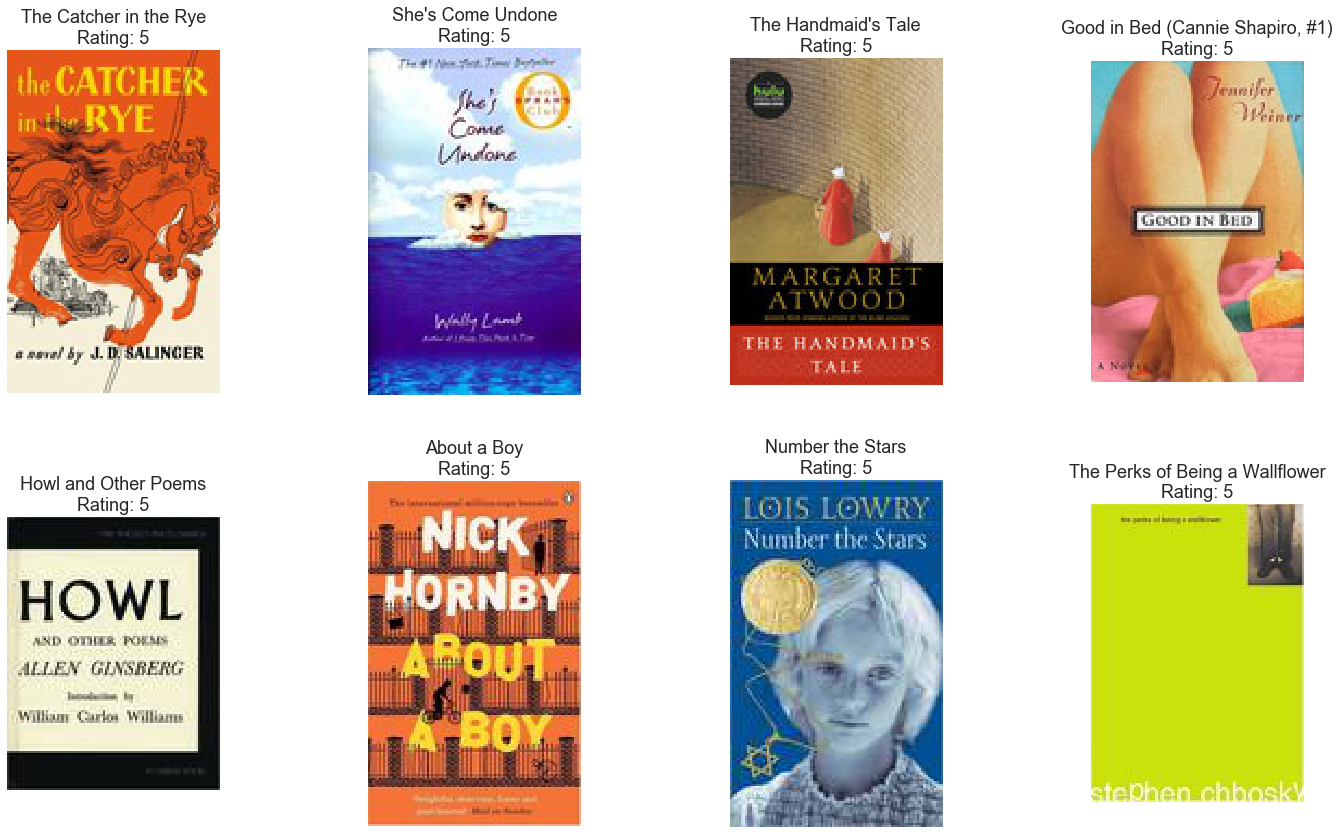



User_15 8 least favorite books:


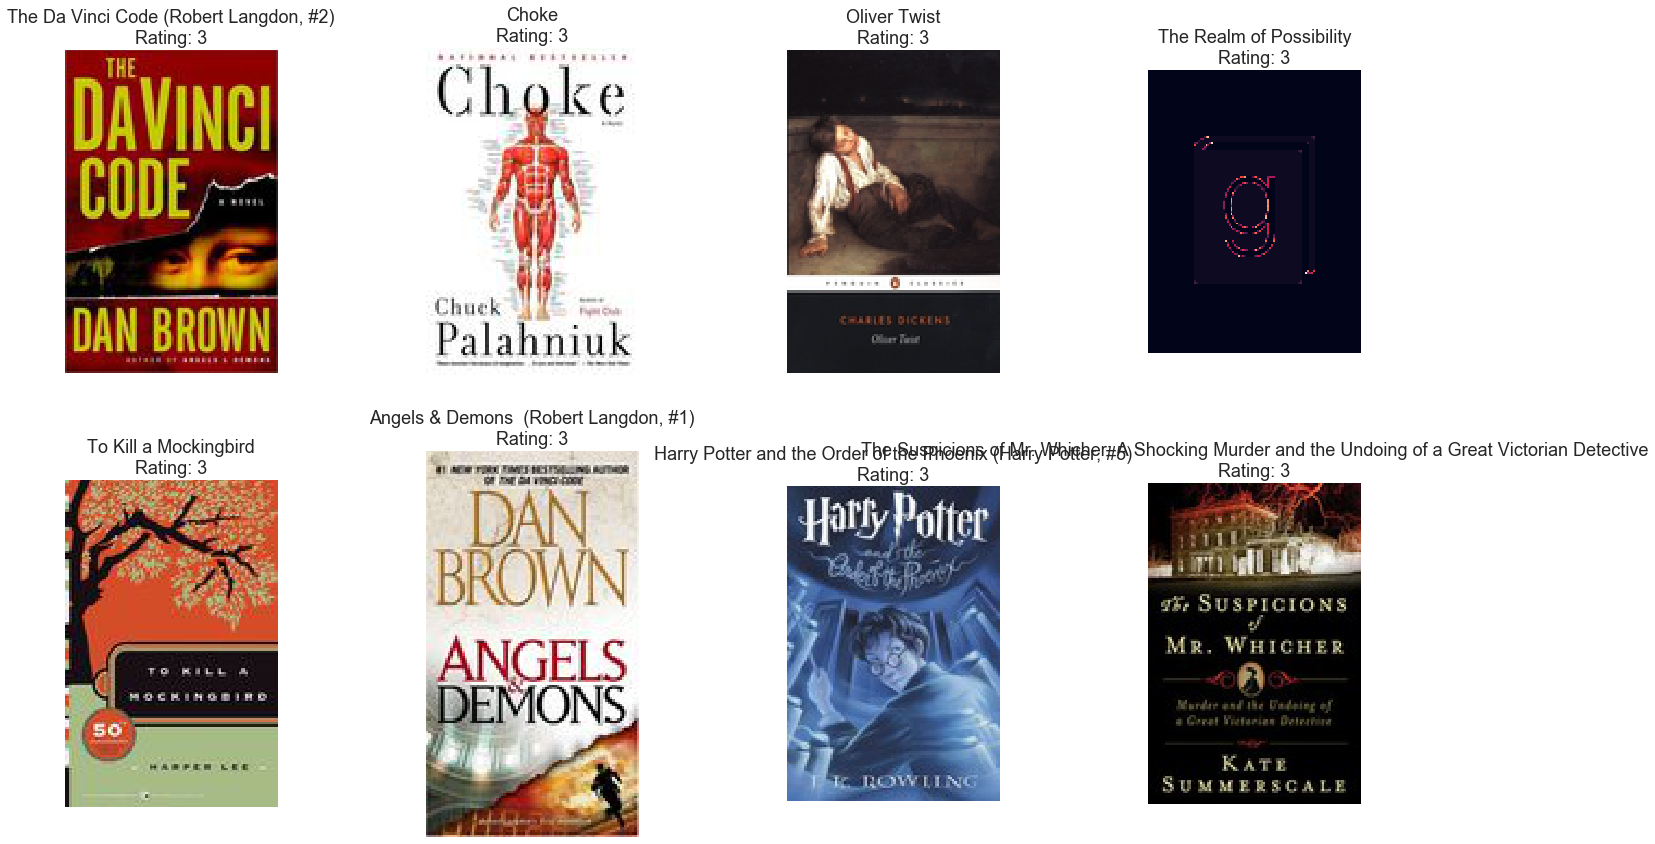

In [116]:
# number of books to show
n = 8

from PIL import Image
import requests
from io import BytesIO

# userid book_id and ratings
userid_table = ratings[ratings.user_id == userid].sort_values('rating', ascending=False)

# show top favorite books
print("User_{} {} favorite books:".format(userid, n))

for i, j in enumerate(userid_table['book_id'][:n]):  
    url = books_new[books_new['book_id'] == j]['image_url'].values[0] # url with the image of the book j
    img = Image.open(BytesIO(requests.get(url).content)) # get image 
    book_title = books_new[books_new['book_id'] == j].title.values[0] # get title
    
    plt.subplot(np.ceil(n/4), 4, i+1) # 4 plots per row
    plt.axis('off')
    plt.imshow(img)
    plt.title("{}\nRating: {}".format(book_title, userid_table['rating'].iloc[i]), fontsize=18)
plt.subplots_adjust(left=0, bottom=-np.ceil(n/4), right=3, top=1, wspace=0.7, hspace=0)
plt.show()

# show least favorite books
print("\n\nUser_{} {} least favorite books:".format(userid, n))

for i, j in enumerate(userid_table['book_id'][-n:]):  
    url = books_new[books_new['book_id'] == j]['image_url'].values[0] # url with the image of the book j
    img = Image.open(BytesIO(requests.get(url).content)) # get image 
    book_title = books_new[books_new['book_id'] == j].title.values[0] # get title
    
    plt.subplot(np.ceil(n/4), 4, i+1) # 4 plots per row
    plt.axis('off')
    plt.imshow(img)
    plt.title("{}\nRating: {}".format(book_title, userid_table.tail(n)['rating'].iloc[i]), fontsize=18)
plt.subplots_adjust(left=0, bottom=-np.ceil(n/4), right=3, top=1, wspace=0.7, hspace=0)
plt.show()


Recommended books for this user:

User_15 10 recommended books:


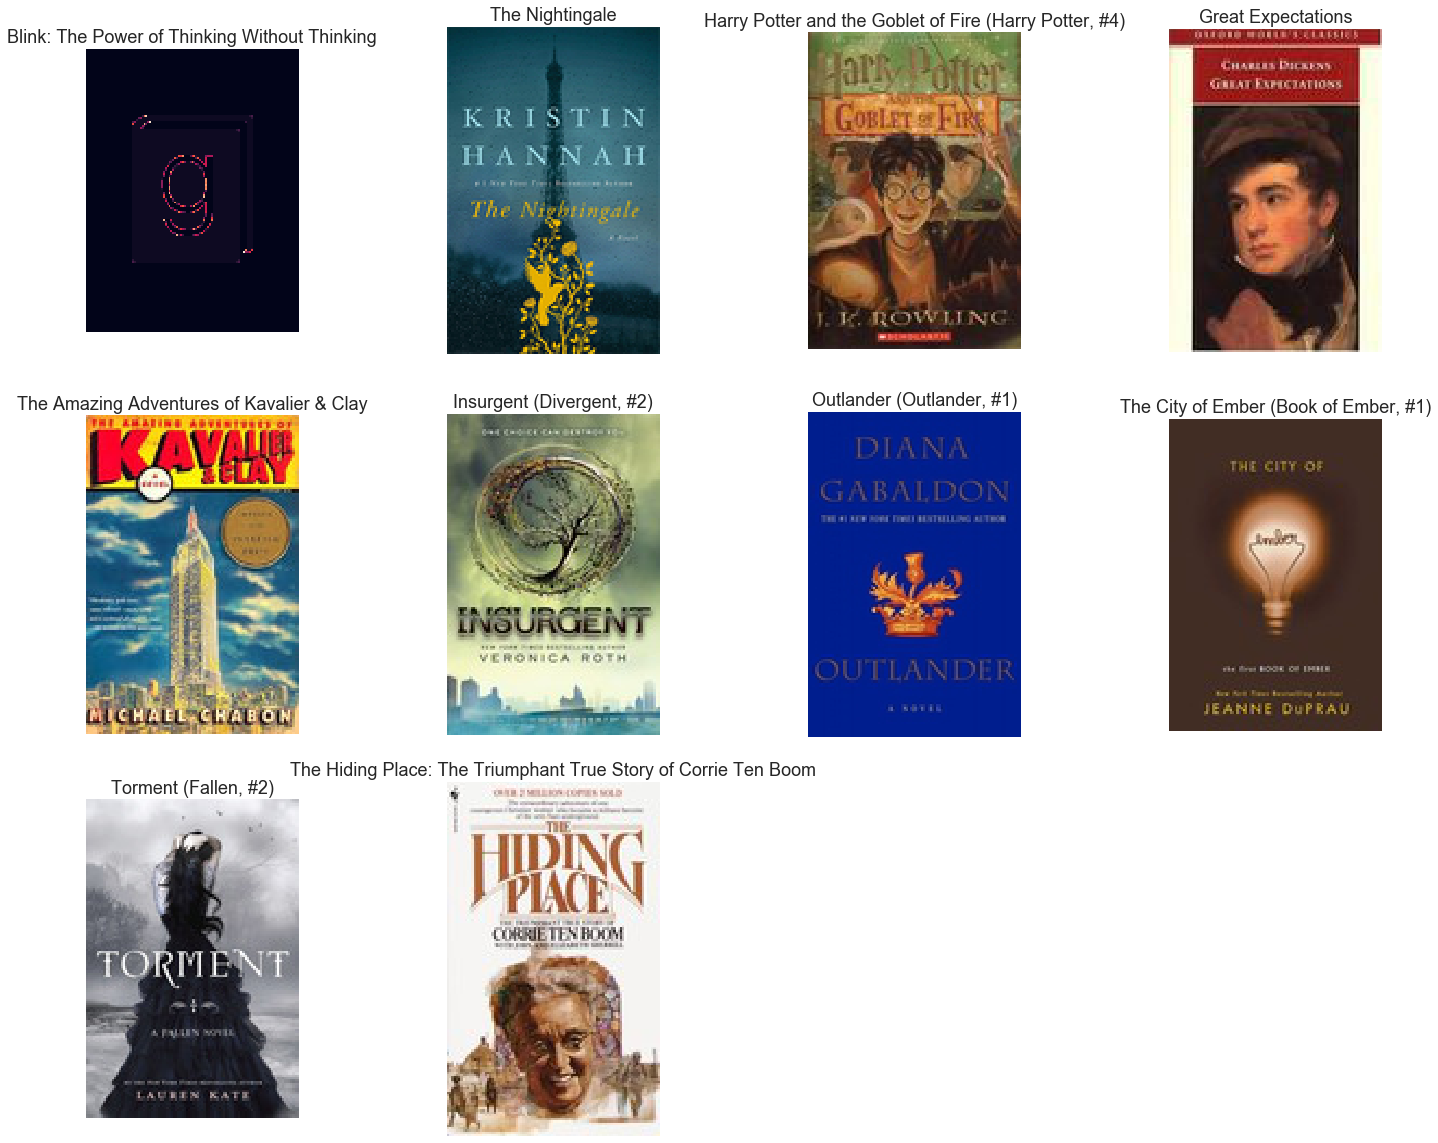

In [117]:
# recommended books
recommendations = model.recommend(userid, user_books)

# number of recommendations and id's
rec_nr = len(recommendations)
rec_ids = [i[0] for i in recommendations]

print("User_{} {} recommended books:".format(userid, rec_nr))

for i, j in enumerate(rec_ids):
    url = books_new[books_new['book_id'] == j]['image_url'].values[0] # url with the image of the book j
    img = Image.open(BytesIO(requests.get(url).content)) # get image 
    book_title = books_new[books_new['book_id'] == j].title.values[0] # get title
    
    plt.subplot(np.ceil(rec_nr/4), 4, i+1) # 4 plots per row
    plt.axis('off')
    plt.imshow(img)
    plt.title("{}".format(book_title), fontsize=18)
plt.subplots_adjust(left=0, bottom=-np.ceil(rec_nr/4), right=3, top=1, wspace=0.7, hspace=0)
plt.show()

Based on the content of the recommended books and the books the user read, it seems they are somewhat accurate based on an **implicit** model.

Now, this **prediction_matrix** function will return the normalized prediction for each item and each user:

In [118]:
from sklearn.preprocessing import MinMaxScaler

def prediction_matrix(user_vecs, item_vecs):
    item_factors_matrix = item_vecs.T  
    
    rec_matrix = user_vecs.dot(item_factors_matrix) # dot product of user vector and all item vectors
    
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    min_max.fit(rec_matrix)
    rec_matrix_scaled = min_max.transform(rec_matrix)
   
    return rec_matrix_scaled


In [119]:
# length: number of users in the matrix
print(len(prediction_matrix(user_vecs, item_vecs)))

# define the predictions matrix
output_predictions = prediction_matrix(user_vecs, item_vecs)
output_predictions

53424


array([[0.83378184, 0.67288923, 0.54113555, ..., 0.34240827, 0.28029308,
        0.37461886],
       [0.56209743, 0.5197768 , 0.8894328 , ..., 0.34165868, 0.30366963,
        0.37508747],
       [0.56642306, 0.56819075, 0.586578  , ..., 0.32639495, 0.295436  ,
        0.3519211 ],
       ...,
       [0.68807393, 0.37762362, 0.4525327 , ..., 0.3440198 , 0.326107  ,
        0.34386984],
       [0.43460065, 0.48816958, 0.45511323, ..., 0.40455496, 0.3690627 ,
        0.4007944 ],
       [0.49973226, 0.12098885, 0.52708733, ..., 0.42387718, 0.39947236,
        0.44364515]], dtype=float32)

### 3.2) Using XGBoost Classifier

In [120]:
# create new dataframe and add two new columns: ALS and label
xgboost_data = ratings.copy()
xgboost_data = xgboost_data.assign(ALS=0, label=1)

xgboost_data.head()

,user_id,book_id,rating,ALS,label
0,1,258,5,0,1
1,2,4081,4,0,1
2,2,260,5,0,1
3,2,9296,5,0,1
4,2,2318,3,0,1


In [121]:
xgboost_data.shape

(5976479, 5)

In [122]:
users_unique = xgboost_data['user_id'].unique()
books_unique = xgboost_data['book_id'].unique()

In [123]:
# prepare a matrix of random negatives
xgboost_negatives = xgboost_data.copy()
random_list = np.random.choice(books_unique, xgboost_data.shape[0]) # 5976479 - sample with replacement
xgboost_negatives['book_id'] = random_list
xgboost_negatives['label'] = 0

In [124]:
xgboost_negatives.head()

,user_id,book_id,rating,ALS,label
0,1,5037,5,0,0
1,2,3999,4,0,0
2,2,8413,5,0,0
3,2,5261,5,0,0
4,2,223,3,0,0


In [125]:
xgboost_data.head()

,user_id,book_id,rating,ALS,label
0,1,258,5,0,1
1,2,4081,4,0,1
2,2,260,5,0,1
3,2,9296,5,0,1
4,2,2318,3,0,1


In [126]:
# duplicate the size, taking the two dataframes together (different labels)
xgboost_data_final = pd.concat([xgboost_data, xgboost_negatives])
xgboost_data_final.head()

,user_id,book_id,rating,ALS,label
0,1,258,5,0,1
1,2,4081,4,0,1
2,2,260,5,0,1
3,2,9296,5,0,1
4,2,2318,3,0,1


In [127]:
xgboost_data_final.tail()

,user_id,book_id,rating,ALS,label
5976474,49925,1410,5,0,0
5976475,49925,5978,4,0,0
5976476,49925,278,4,0,0
5976477,49925,7089,5,0,0
5976478,49925,3885,4,0,0


In [128]:
xgboost_data_final.shape

(11952958, 5)

In [129]:
users_index = pd.DataFrame({'User': users_unique, 'Pos': np.arange(users_unique.size)}, index=users_unique)
books_index = pd.DataFrame({'Book': books_unique, 'Pos': np.arange(books_unique.size)}, index=books_unique)

In [130]:
users_index.head()

,User,Pos
1,1,0
2,2,1
4,4,2
6,6,3
8,8,4


In [131]:
books_index.head()

,Book,Pos
258,258,0
4081,4081,1
260,260,2
9296,9296,3
2318,2318,4


In [132]:
def set_ALS_values(data, users, books, predictions_matrix):
    x = np.array(users.Pos[data['user_id']])
    y = np.array(books.Pos[data['book_id']])
    data['ALS'] = predictions_matrix[x, y]   

In [133]:
%%time

# apply the function to attribute the values for the ALS column
set_ALS_values(xgboost_data_final, users_index, books_index, output_predictions)


Wall time: 2.41 s


In [134]:
xgboost_data_final.head()

,user_id,book_id,rating,ALS,label
0,1,258,5,0.833782,1
1,2,4081,4,0.519777,1
2,2,260,5,0.889433,1
3,2,9296,5,0.650317,1
4,2,2318,3,0.791124,1


In [135]:
xgboost_data_final.tail()

,user_id,book_id,rating,ALS,label
5976474,49925,1410,5,0.622101,0
5976475,49925,5978,4,0.389023,0
5976476,49925,278,4,0.336631,0
5976477,49925,7089,5,0.706256,0
5976478,49925,3885,4,0.234417,0


In [136]:
xgboost_data_final.shape

(11952958, 5)

We will now **split into training and test set**. Again, with a 80-20% rule.

In [137]:
from sklearn.model_selection import train_test_split

X_xgb = xgboost_data_final.drop('label', axis=1)
y_xgb = xgboost_data_final['label']

# Split into train (80%) and test (20%) sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)


In [138]:


# parar aqui



Now we will implement a state of the art algorithm, the **Extreme Gradient Boosting (XGBoost)** algorithm.

In [141]:
%%time

import xgboost as xgb

# instantiate the model
xgb_clf = xgb.XGBClassifier()

# train the model
xgb_clf.fit(X_train_xgb, y_train_xgb)


[19:35:52] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Wall time: 33min 51s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

**Evaluate the model:**

In [142]:
# evaluate the model
xgb_pred = xgb_clf.predict(X_test_xgb)

from sklearn.metrics import roc_auc_score, classification_report

# ROC AUC score
roc_auc_score_xgb = roc_auc_score(y_test_xgb, xgb_pred)

# RMSE
rmse_score_xgb = np.sqrt(mean_squared_error(y_test_xgb, xgb_pred))

# Classification report
class_report_xgb = classification_report(y_test_xgb, xgb_pred)

print("The ROC AUC score with the {} model is {}".format('XGBClassifier', round(roc_auc_score_xgb, 3)))
print("RMSE score: {}".format(rmse_score_xgb))
print("\nClassification report:\n", class_report_xgb)


The ROC AUC score with the XGBClassifier model is 0.734
RMSE score: 0.5153744052448207

Classification report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75   1195800
           1       0.76      0.68      0.72   1194792

    accuracy                           0.73   2390592
   macro avg       0.74      0.73      0.73   2390592
weighted avg       0.74      0.73      0.73   2390592



### 3.3) Hyperparameter Tuning

### 3.4) Conclusion

In [143]:
##################################################################################

In [144]:
##################################################################################

### 3.2) Explicit Rating Classifiers

In [145]:
# create new dataframe and add the ALS normalized values
clf_data = ratings.copy()
clf_data = clf_data.assign(ALS=0)

clf_data.head()

,user_id,book_id,rating,ALS
0,1,258,5,0
1,2,4081,4,0
2,2,260,5,0
3,2,9296,5,0
4,2,2318,3,0


Now, fill the ALS with the normalized values of the previous ALS model we have build.

In [146]:
# create user_index and books_index dataframes for support in the following function we will define
users_index = pd.DataFrame({'User': users_unique, 'Pos': np.arange(users_unique.size)}, index=users_unique)
books_index = pd.DataFrame({'Book': books_unique, 'Pos': np.arange(books_unique.size)}, index=books_unique)

# Note: users_unique and books_unique are the same either computed with clf_data or xgboost_data
#       (it's ratings.copy() with ALS column = 0), so it's ok.

In [147]:
users_index.head()

,User,Pos
1,1,0
2,2,1
4,4,2
6,6,3
8,8,4


In [148]:
books_index.head()

,Book,Pos
258,258,0
4081,4081,1
260,260,2
9296,9296,3
2318,2318,4


In [149]:
# function to define the ALS values for each user/book combination
def set_ALS_values(data, users, books, predictions_matrix):
    x = np.array(users.Pos[data['user_id']])
    y = np.array(books.Pos[data['book_id']])
    data['ALS'] = predictions_matrix[x, y]  
    

In [150]:
%%time

# apply the function to attribute the values for the ALS column
set_ALS_values(clf_data, users_index, books_index, output_predictions)


Wall time: 36.2 s


In [151]:
clf_data.head()

,user_id,book_id,rating,ALS
0,1,258,5,0.833782
1,2,4081,4,0.519777
2,2,260,5,0.889433
3,2,9296,5,0.650317
4,2,2318,3,0.791124


In [152]:
clf_data.shape

(5976479, 4)

We will now **split into training and test set**. Again, with a 80-20% rule.

In [153]:
from sklearn.model_selection import train_test_split

X = clf_data.drop('rating', axis=1)
y = clf_data['rating']

# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# stratify=y ---> so that the train and test sets have the same proportion of class labels

Now we will implement a state of the art algorithm, the **Extreme Gradient Boosting (XGBoost)** algorithm.

In [154]:
%%time

import xgboost as xgb

# instantiate the model
clf_xgb = xgb.XGBClassifier()

# train the model
clf_xgb.fit(X_train, y_train)


[20:10:45] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Wall time: 1h 16min 2s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

**Evaluate the model:**

In [155]:
# evaluate the model
pred_xgb = clf_xgb.predict(X_test)

from sklearn.metrics import roc_auc_score, classification_report, mean_squared_error

# ROC AUC score
# xgb_roc_auc_score = roc_auc_score(y_test, pred_xgb)

# RMSE
xgb_rmse_score = np.sqrt(mean_squared_error(y_test, pred_xgb))

# Classification report
xbg_class_report = classification_report(y_test, pred_xgb)

# print("The ROC AUC score with the {} model is {}".format('XGBClassifier', round(xgb_roc_auc_score, 3)))
print("RMSE score: {}".format(xgb_rmse_score))
print("\nClassification report:\n", xbg_class_report)


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RMSE score: 1.165157755975933

Classification report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00     24839
           2       0.00      0.00      0.00     71851
           3       0.00      0.00      0.00    274183
           4       0.37      0.65      0.47    427804
           5       0.38      0.42      0.40    396619

    accuracy                           0.37   1195296
   macro avg       0.15      0.21      0.17   1195296
weighted avg       0.26      0.37      0.30   1195296



In [156]:
# prediction probabilities for each rating (1 to 5)
pred_proba_xgb = clf_xgb.predict_proba(X_test)
pred_proba_xgb

array([[0.02003685, 0.05992868, 0.23843622, 0.35378194, 0.32781634],
       [0.01895951, 0.0555898 , 0.2241881 , 0.35787326, 0.3433893 ],
       [0.01815554, 0.05653533, 0.24509391, 0.3614706 , 0.31874463],
       ...,
       [0.01905458, 0.07247689, 0.28646266, 0.38906989, 0.23293595],
       [0.02525541, 0.05808111, 0.20011535, 0.33094704, 0.38560104],
       [0.01821304, 0.05179771, 0.22384463, 0.357996  , 0.3481486 ]],
      dtype=float32)

In [157]:
# see predictions and recommendations
df_predictions = X_test.copy()

df_predictions['rating'] = y_test
df_predictions['prediction_rating'] = pred_xgb

# absolute error
df_predictions['error'] = abs(df_predictions['prediction_rating'] - df_predictions['rating'])

# five star prediction probabilities
df_predictions['five_star_pred_proba'] = [i[4] for i in pred_proba_xgb]

df_predictions.head()


,user_id,book_id,ALS,rating,prediction_rating,error,five_star_pred_proba
1438878,20745,833,0.472197,3,4,1,0.327816
2722349,34844,2075,0.486607,5,4,1,0.343389
1541266,21959,5590,0.440488,5,4,1,0.318745
1611514,22680,7696,0.419845,4,4,0,0.318888
3200606,32633,1893,0.368437,5,4,1,0.347445


In [158]:
# RMSE - check
np.sqrt(np.mean(df_predictions['error']**2))

1.165157755975933

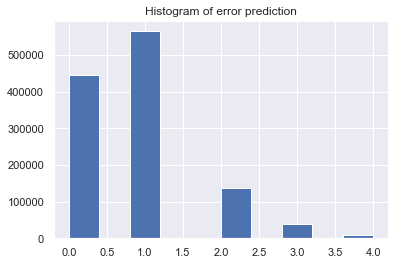

In [159]:
# histogram of error
plt.hist(df_predictions['error'])
plt.title('Histogram of error prediction')
plt.show()

**Check recommendations**:

In [160]:
# choose user_id
userid = 15

# number of recommendations
n = 8

# top recommendations
rec_df = df_predictions[df_predictions['user_id'] == userid].sort_values('five_star_pred_proba', ascending=False).head(n)

print("User {} recommendations average rating: {}".format(userid, np.mean(rec_df['rating'])))
rec_df

User 15 recommendations average rating: 4.75


,user_id,book_id,ALS,rating,prediction_rating,error,five_star_pred_proba
185,15,2,0.470003,4,4,0,0.359802
218249,15,3,0.382295,5,5,0,0.346418
184,15,8,0.658597,5,4,1,0.311687
195,15,13,0.664400,4,4,0,0.306910
206,15,167,0.405922,5,4,1,0.280515
187,15,101,0.434358,5,4,1,0.279573
228,15,68,0.437584,5,4,1,0.279540
241,15,115,0.505592,5,4,1,0.276093


In [161]:
# calculate average rating - of all users
